<a href="https://colab.research.google.com/github/daradanci/DeepLearning/blob/main/DZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 1

## Импортирование необходимых библиотек

In [1]:
from PIL import Image
from glob import glob
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
from tensorflow import summary as tfsummary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Чтение тренировочной и тестовой выборки

Инструкция для скачивания и загрузки фотографий в Сolab находится в github

In [3]:
# Подключаем Google Диск
drive.mount('/content/drive')

# Указываем путь к папке с изображениями на Google Диске
base_path = '/content/drive/MyDrive/Изображения_ДЗ1_РНС/'

heigth_width = 32

CLASSES = ['Паук', 'Муравей', 'Скорпион']  # Ваши классы

images = []
images_t = []
classes = []
classes_t = []

for CLASS in CLASSES:
    path_class = os.path.join(base_path, CLASS, '*.*')  # Путь к файлам в папке
    image_paths = glob(path_class)
    total_images = len(image_paths)
    split_index = int(total_images * 0.8)  # 80% для обучения, 20% для теста

    for i, photo in enumerate(image_paths):
        img = Image.open(photo).convert('RGB')
        img = img.resize((heigth_width, heigth_width))

        if i >= split_index:
            images_t.append(np.asarray(img))
            classes_t.append(CLASSES.index(CLASS))
        else:
            images.append(np.asarray(img))
            classes.append(CLASSES.index(CLASS))

train_X = np.array(images)
train_y = np.array(classes)

test_X = np.array(images_t)
test_y = np.array(classes_t)

print("Размер train_X:", train_X.shape)
print("Размер train_y:", train_y.shape)
print("Размер test_X:", test_X.shape)
print("Размер test_y:", test_y.shape)

Mounted at /content/drive
Размер train_X: (240, 32, 32, 3)
Размер train_y: (240,)
Размер test_X: (60, 32, 32, 3)
Размер test_y: (60,)


###Приведение фотографий к требуемому размеру

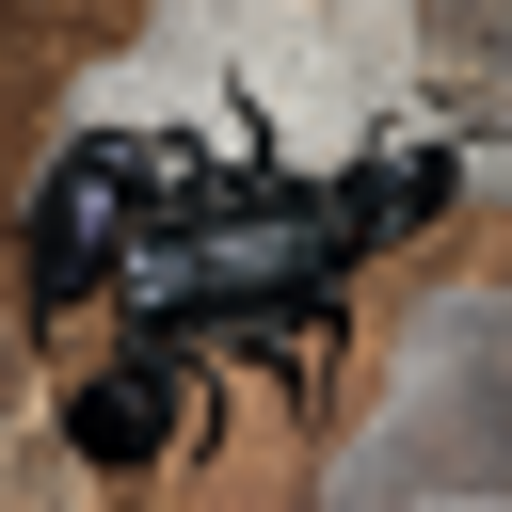

In [4]:
Image.fromarray(train_X[200]).resize((512,512))

##Создание Pytorch DataLoader'a

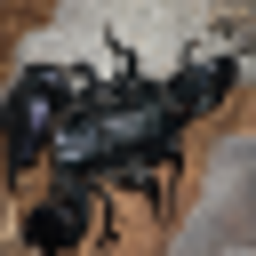

In [5]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p

     def __len__(self):
         return self.y.size(0)

     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                    shear=5),
])

Image.fromarray((transform(torch.Tensor(train_X[200]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

In [6]:
batch_size = 32
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7af267ae81d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7af2701de2d0>}

In [ ]:
# batch_size = 33
# dataloader = {}
# for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
#                         ['train', 'test']):
#     tensor_x = torch.Tensor(X)
#     tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
#                                      num_classes=len(CLASSES))/1.
#     dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
#     dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
# dataloader

##Создание Pytorch модели

In [7]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, HIDDEN_SIZE, 3, stride=4),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),#nn.MaxPool2d(4),
            nn.Dropout2d(p=0.3),
            nn.Flatten(),
            nn.Linear(HIDDEN_SIZE*8, classes),
        )

    def forward(self, input):
        return self.seq(input)

model = torch.hub.load("chenyaofo/pytorch-cifar-models",
                       "cifar100_mobilenetv2_x0_5",
                      #  'cifar100_resnet20',
                       pretrained=True)
model.to(device)
new_model = nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),# https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    model
).to(device)
print(new_model(torch.rand(1, 32, 32, 3).to(device)))
summary(new_model, input_size=(32, 32, 3))
new_model

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x0_5-9f915757.pt" to /root/.cache/torch/hub/checkpoints/cifar100_mobilenetv2_x0_5-9f915757.pt
100%|██████████| 3.29M/3.29M

tensor([[-1.0054, -0.0535,  0.1501,  0.6058,  0.4886, -0.4791, -1.0201,  0.8745,
          0.3486,  0.8857,  1.2314,  0.7848, -0.3455, -0.2447, -0.0928,  0.7932,
         -0.2437, -0.0987,  0.7641,  0.3987, -0.7055,  0.7417,  0.6594, -0.6823,
         -0.1240, -0.1100,  0.1044, -0.2045, -0.2102,  1.2653, -0.4974, -0.2419,
          1.2915,  0.2729,  0.0803, -0.1026,  0.0639,  0.4961,  0.0057, -0.6071,
          0.9352,  0.1913,  0.2547, -0.3967,  0.5342,  0.5250,  1.0124, -1.2909,
         -0.3485, -0.5796,  0.5834,  0.4261, -2.0419, -0.7998, -0.5864,  0.7497,
         -0.2213,  0.9734, -1.3450, -0.3388, -1.0482,  0.0860, -0.0650,  0.1645,
          0.7916,  0.5855,  0.3690,  1.0131, -0.0165, -0.0502, -0.7873, -1.0809,
          0.9286,  0.3010, -0.2031,  0.0817, -0.9462,  0.2875,  0.6802,  0.5677,
          0.1620, -1.3333,  0.0165, -0.6624, -0.0263, -0.1594, -0.3370,  0.6044,
         -0.1394, -0.3314,  0.4173,  0.7975, -0.7770, -0.2060, -1.3577, -1.0433,
         -0.5068, -0.0232, -

Sequential(
  (0): Normalize()
  (1): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(8, 48, kernel_size=(1, 1

In [8]:
## resnet20
# in_features = new_model[1].fc.in_features
# new_model[1].fc = nn.Linear(in_features=in_features,
#                             out_features=len(CLASSES),
#                             bias=True)
## mobilenetv2
in_features = new_model[1].classifier[1].in_features
new_model[1].classifier[1] = nn.Linear(in_features=in_features,
                                      out_features=len(CLASSES),
                                      bias=True)

new_model.to(device)
summary(new_model, input_size=(32, 32, 3))
print(new_model(torch.rand(1, 32, 32, 3).to(device)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
             ReLU6-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             144
       BatchNorm2d-6           [-1, 16, 32, 32]              32
             ReLU6-7           [-1, 16, 32, 32]               0
            Conv2d-8            [-1, 8, 32, 32]             128
       BatchNorm2d-9            [-1, 8, 32, 32]              16
 InvertedResidual-10            [-1, 8, 32, 32]               0
           Conv2d-11           [-1, 48, 32, 32]             384
      BatchNorm2d-12           [-1, 48, 32, 32]              96
            ReLU6-13           [-1, 48, 32, 32]               0
           Conv2d-14           [-1, 48,

## Заморозка весов и обучение модели

In [14]:
print("Обучаемые параметры:")
keep_last = 65
total = len([*new_model.named_parameters()])
params_to_update = []
for i, (name, param) in enumerate(new_model.named_parameters()):
    if i < total - keep_last:
        param.requires_grad = False
    else:
        params_to_update.append(param)
        param.requires_grad = True
        print("\t",name)
summary(new_model, input_size=(32, 32, 3))

Обучаемые параметры:
	 1.features.11.conv.1.0.weight
	 1.features.11.conv.1.1.weight
	 1.features.11.conv.1.1.bias
	 1.features.11.conv.2.weight
	 1.features.11.conv.3.weight
	 1.features.11.conv.3.bias
	 1.features.12.conv.0.0.weight
	 1.features.12.conv.0.1.weight
	 1.features.12.conv.0.1.bias
	 1.features.12.conv.1.0.weight
	 1.features.12.conv.1.1.weight
	 1.features.12.conv.1.1.bias
	 1.features.12.conv.2.weight
	 1.features.12.conv.3.weight
	 1.features.12.conv.3.bias
	 1.features.13.conv.0.0.weight
	 1.features.13.conv.0.1.weight
	 1.features.13.conv.0.1.bias
	 1.features.13.conv.1.0.weight
	 1.features.13.conv.1.1.weight
	 1.features.13.conv.1.1.bias
	 1.features.13.conv.2.weight
	 1.features.13.conv.3.weight
	 1.features.13.conv.3.bias
	 1.features.14.conv.0.0.weight
	 1.features.14.conv.0.1.weight
	 1.features.14.conv.0.1.bias
	 1.features.14.conv.1.0.weight
	 1.features.14.conv.1.1.weight
	 1.features.14.conv.1.1.bias
	 1.features.14.conv.2.weight
	 1.features.14.conv.3.weig

In [15]:
# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
# optimizer = optim.SGD(params_to_update, lr=3e-4, momentum=0.9,
#                       weight_decay=1e-5)
# optimizer = optim.Adagrad(params_to_update, lr=3e-4, weight_decay=1e-5)
# optimizer = optim.RMSprop(params_to_update, lr=3e-4, momentum=0.9, weight_decay=1e-5)
optimizer = optim.Adam(params_to_update, lr=3e-4, betas=(0.9, 0.999), weight_decay=1e-4)
# добавляем постепенное уменьшение шага обучения каждые 20 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

Эпоха: 50
Лучшая доля правильных ответов: 86.83036041259766
Текущая доля правильных ответов: 85.26786041259766


  0%|          | 0/400 [00:00<?, ?it/s]

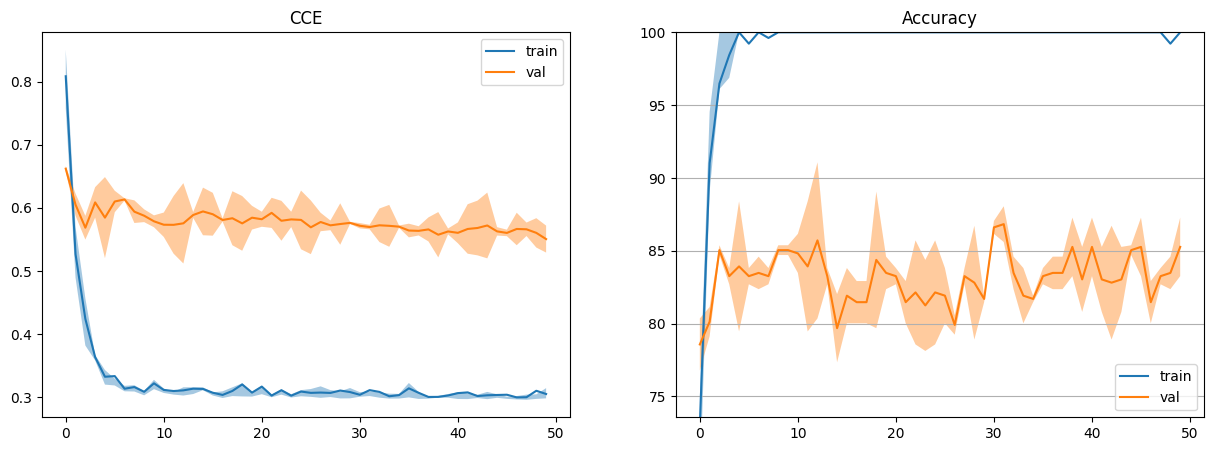

Обучение закончено за 23.750428199768066 секунд


In [16]:
EPOCHS = 50
REDRAW_EVERY = 10
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_acc = 0
checkpoint_path = 'cifar_cnn_fine.pth'
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    new_model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    new_model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    if acc > best_acc:
        best_acc = acc
        torch.save(new_model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучшая доля правильных ответов: %s\n'
          'Текущая доля правильных ответов: %s' % (epoch+1, best_acc, acc))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
new_model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

##Проверка качества модели по классам на обучающей и тестовой выборках

In [17]:
batch_size = 32
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform=None,
                           p=0.0) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  num_workers=2, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7af2657b8310>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7af2657bbe50>}

In [18]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

        Паук     1.0000    1.0000    1.0000        80
     Муравей     1.0000    1.0000    1.0000        80
    Скорпион     1.0000    1.0000    1.0000        80

    accuracy                         1.0000       240
   macro avg     1.0000    1.0000    1.0000       240
weighted avg     1.0000    1.0000    1.0000       240

--------------------------------------------------
test
              precision    recall  f1-score   support

        Паук     0.7600    0.9500    0.8444        20
     Муравей     0.9375    0.7500    0.8333        20
    Скорпион     0.9474    0.9000    0.9231        20

    accuracy                         0.8667        60
   macro avg     0.8816    0.8667    0.8670        60
weighted avg     0.8816    0.8667    0.8670        60

--------------------------------------------------


##Сохранение модели в ONNX

In [ ]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [23]:
# входной тензор для модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[1, 32, 32, 3] to have 3 channels, but got 32 channels instead

In [20]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 65.0 MB/s eta 0:00:00


In [21]:
# Подготовка входного тензора (формат [batch_size, channels, height, width])
x = torch.randn(1, 3, 32, 32).to(device)

# Экспорт модели в ONNX
torch.onnx.export(new_model,                     # финальная модель с кастомным forward
                  x,                         # пример входа
                  "cifar100_exported_DZ1.onnx",  # имя сохраняемого файла
                  export_params=True,        # сохранять веса
                  opset_version=11,          # версия ONNX (>=11 — оптимально)
                  do_constant_folding=True,  # свернуть константы
                  input_names=['input'],     # имя входа
                  output_names=['output'],   # имя выхода
                  dynamic_axes={             # возможность менять batch_size
                      'input': {0: 'batch_size'},
                      'output': {0: 'batch_size'}
                  })

print("✅ Экспорт модели завершён успешно: 'cifar100_exported.onnx'")


RuntimeError: The size of tensor a (32) must match the size of tensor b (3) at non-singleton dimension 3

In [26]:
# Подготовка входного тензора (NHWC, если forward ожидает такой формат)
x = torch.randn(1, 3, 32, 32).permute(0, 2, 3, 1).to(device)  # NCHW -> NHWC

# Экспорт модели в ONNX
torch.onnx.export(new_model,
                  x,
                  "cifar100_exported_DZ1_1.onnx",
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={
                      'input': {0: 'batch_size'},
                      'output': {0: 'batch_size'}
                  })

print("✅ Экспорт модели завершён успешно: 'cifar100_exported_DZ1_1.onnx'")


✅ Экспорт модели завершён успешно: 'cifar100_exported_DZ1_1.onnx'
